# Infer ***peroxisome*** - part 7️⃣

--------------

## OVERVIEW
In notesbooks 4-9, we will go how each organelle is segmented. These segmentation workflows are completely independent of each other and can be run in any order. Additionally, the entire image will be processed in this notebook, irrespective of the single cells identified in notebooks 1-3. The cell mask will be applied to the organelle segmentation outputs before quantification (as outlined in [10_regionprops](./10_regionprops.ipynb)). 

This notebook goes through the workflow steps to segment the ***peroxisomes*** -- one of the six organelles of interest.

## OBJECTIVE: ✅ Infer sub-cellular component  ***peroxisomes***  
Segment the ***peroxisomes*** from a single channel (membrane marker). This workflow was optimized for images of fluorescently tagged SKL, a membrane targeting sequence.


## IMPORTS

In [1]:
# top level imports
from pathlib import Path
import os, sys
from collections import defaultdict
from typing import Optional

import numpy as np

from scipy import ndimage as ndi
from aicssegmentation.core.seg_dot import dot_2d_slice_by_slice_wrapper

from skimage.measure import label

import napari

### import local python functions in ../infer_subc
sys.path.append(os.path.abspath((os.path.join(os.getcwd(), '..'))))

from infer_subc.core.file_io import (read_czi_image,
                                     read_ome_image,
                                     export_inferred_organelle,
                                     import_inferred_organelle,
                                     list_image_files)

from infer_subc.core.img import *                                     
from infer_subc.organelles import fixed_infer_nuclei_fromlabel
# NOTE:  these "constants" are only accurate for the testing MCZ dataset
from infer_subc.constants import (TEST_IMG_N,
                                                                    NUC_CH ,
                                                                    LYSO_CH ,
                                                                    MITO_CH ,
                                                                    GOLGI_CH ,
                                                                    PEROX_CH ,
                                                                    ER_CH ,
                                                                    LD_CH ,
                                                                    RESIDUAL_CH )  

LD_CH = 0
NUC_CH = 1
LYSO_CH = 2
MITO_CH = 3
GOLGI_CH = 4
PEROX_CH = 5
ER_CH = 6
PM_CH = 7
RESIDUAL_CH = 8
TEST_IMG_N = 0


%load_ext autoreload
%autoreload 2

## Get and load Image for processing

In [2]:
test_img_n = TEST_IMG_N

data_root_path = Path(os.path.expanduser("~")) /  "Documents/Python Scripts/Infer-subc-2D"

in_data_path = data_root_path / "raw"
im_type = ".tiff"

img_file_list = list_image_files(in_data_path,im_type)
test_img_name = img_file_list[test_img_n]

out_data_path = data_root_path / "out"
if not Path.exists(out_data_path):
    Path.mkdir(out_data_path)
    print(f"making {out_data_path}")

In [3]:
img_data,meta_dict = read_czi_image(test_img_name)

channel_names = meta_dict['name']
img = meta_dict['metadata']['aicsimage']
scale = meta_dict['scale']
channel_axis = meta_dict['channel_axis']

---------------------

## infer ***peroxisome***

## summary of steps 

➡️ INPUT
- select single channel containing the mitochondria marker (channel number = user input)

PRE-PROCESSING
- rescale image intensities: 
    - min=0, max=1
- smooth image:
    - median filter (media size = user input)
    - gaussian filter (sigma = user input)

CORE PROCESSING
- apply "dot" thresholding method (for small round objects) from the Allen Cell [aicssegmentation](https://github.com/AllenCell/aics-segmentation) package (size scale and threshold cutoff = user input)

POST-PROCESSING
- fill holes (hole size = user input)
- remove small objects (object size = user input)

OUTPUT ➡️
- label unique mitochondria objects based on connectivity
- save labeled ***mitochondria*** (mito, MT) as unsigned integer 16-bit tif files



> Generally following the Allen Cell Segmenter procedure for segmentation of perixisomes from the [playground_dots.ipynb](https://github.com/AllenInstitute/aics-segmentation/blob/master/lookup_table_demo/playground_dots.ipynb) notebook.

## EXTRACT prototype

In [4]:
###################
# INPUT
###################
raw_perox = select_channel_from_raw(img_data, PEROX_CH)

## PRE-PROCESSING prototype

In [5]:
###################
# PRE_PROCESSING
###################
median_sz = 0
gauss_sig = 1.34

struct_img =  scale_and_smooth(raw_perox,
                               median_size = median_sz,
                               gauss_sigma = gauss_sig)

## CORE PROCESSING prototype

In [6]:
###################
# CORE_PROCESSING
###################
# segment small round structures with this
dot_method = "3D"

bw_extra = dot_filter_3(struct_img, 1, 0.06, 0, 0, 0, 0, dot_method)

## POST-PROCESSING prototype

In [7]:
###################
# POST_PROCESSING
###################
hole_min_width = 0
hole_max_width = 0

small_object_width = 2

fill_filter_method = "3D"

cleaned_img2 = fill_and_filter_linear_size(bw_extra, 
                                           hole_min=hole_min_width, 
                                           hole_max=hole_max_width, 
                                           min_size=small_object_width,
                                           method=fill_filter_method)

## LABELING prototype

In [8]:
###################
# LABELING
###################
peroxisomes_labels = label_uint16(cleaned_img2)

In [9]:
peroxisomes_labels.dtype

dtype('uint16')

## Visualize with `napari`
Visualize the first-pass segmentation and labeling with `napari`.

In [10]:
viewer = napari.Viewer()

30-Jan-24 15:23:52 - vispy    - WARNING  - QWindowsWindow::setGeometry: Unable to set geometry 1280x1208+12+46 (frame: 1302x1264+1+1) on QWidgetWindow/"_QtMainWindowClassWindow" on "\\.\DISPLAY1". Resulting geometry: 1280x1050+12+46 (frame: 1302x1106+1+1) margins: 11, 45, 11, 11 minimum size: 385x491 MINMAXINFO maxSize=0,0 maxpos=0,0 mintrack=792,1038 maxtrack=0,0)


In [11]:
viewer.add_image(
    struct_img)

viewer.add_image(
    cleaned_img2,
    opacity=0.3)

viewer.add_image(
    peroxisomes_labels,
    opacity=0.3)

<Image layer 'peroxisomes_labels' at 0x2ad4658cc10>

## SAVE inferred peroxisome to .tif file

In [12]:
out_file_n = export_inferred_organelle(peroxisomes_labels, "perox", meta_dict, out_data_path)

saved file: 11252023_MSi08L_iPSCs_undiff_BR1_N07_Unmixing_0_cmle.ome-perox


----------
## DEFINE `infer_perox` function

Based on the _prototyping_ above define the function to infer the peroxisome.  

> NOTE: these functions mainly serve for downstream prototyping in the notebooks. Each step above has an independent function that is implemented in the plugin for easy of use.

In [13]:
##########################
#  infer_perox
##########################
def _infer_perox( 
        in_img: np.ndarray,
        peroxi_ch: int,
        median_sz: int,
        gauss_sig: float,
        dot_scale_1: float,
        dot_cut_1: float,
        dot_scale_2: float,
        dot_cut_2: float,
        dot_scale_3: float,
        dot_cut_3: float,
        dot_method: str,
        hole_min_width: int,
        hole_max_width: int,
        small_object_width: int,
        fill_filter_method: str
        ) -> np.ndarray:
    """
    Procedure to infer peroxisome from linearly unmixed input.

   Parameters
    ------------
    in_img: 
        a 3d image containing all the channels
    median_sz: 
        width of median filter for signal
    gauss_sig: 
        sigma for gaussian smoothing of  signal
    dot_scale: 
        scales (log_sigma) for dot filter (1,2, and 3)
    dot_cut: 
        threshold for dot filter thresholds (1,2,and 3)
    small_obj_w: 
        minimu object size cutoff for nuclei post-processing
 
    Returns
    -------------
    peroxi_object
        mask defined extent of peroxisome object
    """

    ###################
    # EXTRACT
    ###################    
    peroxi = select_channel_from_raw(in_img, peroxi_ch)

    ###################
    # PRE_PROCESSING
    ###################    
    peroxi =  scale_and_smooth(peroxi,
                               median_size = median_sz,
                               gauss_sigma = gauss_sig)

   ###################
    # CORE_PROCESSING
    ###################
    bw = dot_filter_3(peroxi, dot_scale_1, dot_cut_1, dot_scale_2, dot_cut_2, dot_scale_3, dot_cut_3, dot_method)

    ###################
    # POST_PROCESSING
    ###################
    struct_obj = fill_and_filter_linear_size(bw, 
                                             hole_min=hole_min_width, 
                                             hole_max=hole_max_width, 
                                             min_size=small_object_width,
                                             method=fill_filter_method)

    ###################
    # LABELING
    ###################
    struct_obj1 = label_uint16(struct_obj)

    return struct_obj1


## DEFINE `_fixed_infer_perox` function


In [14]:

##########################
#  fixed_infer_perox
##########################
def _fixed_infer_perox(in_img: np.ndarray) -> np.ndarray:
    """
    Procedure to infer peroxisome from linearly unmixed input with fixed parameters.

   Parameters
    ------------
    in_img: np.ndarray
        a 3d image containing all the channels
        
    Returns
    -------------
    peroxi_object
        mask defined extent of peroxisome object
    """
    peroxi_ch = 4
    median_sz = 0
    gauss_sig = 1.34
    dot_scale_1 = 1
    dot_cut_1 = 0.06
    dot_scale_2 = 0
    dot_cut_2 = 0
    dot_scale_3 = 0
    dot_cut_3 = 0
    dot_method = "3D"
    hole_min_width = 0
    hole_max_width = 0
    small_object_width = 2
    fill_filter_method = "3D"

    return _infer_perox(
        in_img,
        peroxi_ch,
        median_sz,
        gauss_sig,
        dot_scale_1,
        dot_cut_1,
        dot_scale_2,
        dot_cut_2, 
        dot_scale_3,
        dot_cut_3,
        dot_method,
        hole_min_width,
        hole_max_width,
        small_object_width,
        fill_filter_method)

# TEST  `_infer_perox` function

In [15]:
_perox_object =  _fixed_infer_perox(img_data) 

_perox_object.dtype

dtype('uint16')

In [16]:
np.all(peroxisomes_labels == _perox_object)

True

------------------

# TEST `infer_perox` exported functions

The prototype _infer_perox was copied to the [.organelles.perox](../infer_subc/organelles/perox.py) sub-module.

In [17]:
from infer_subc.organelles import infer_perox, fixed_infer_perox 

perox_object =  fixed_infer_perox(img_data) 

In [18]:
np.all(_perox_object == perox_object)

True

## Visualize  2


In [19]:
viewer.add_image(
    _perox_object,
    opacity=0.3)

viewer.add_labels(
    perox_object,
    opacity=0.3)

<Labels layer 'perox_object' at 0x26d6f6334f0>

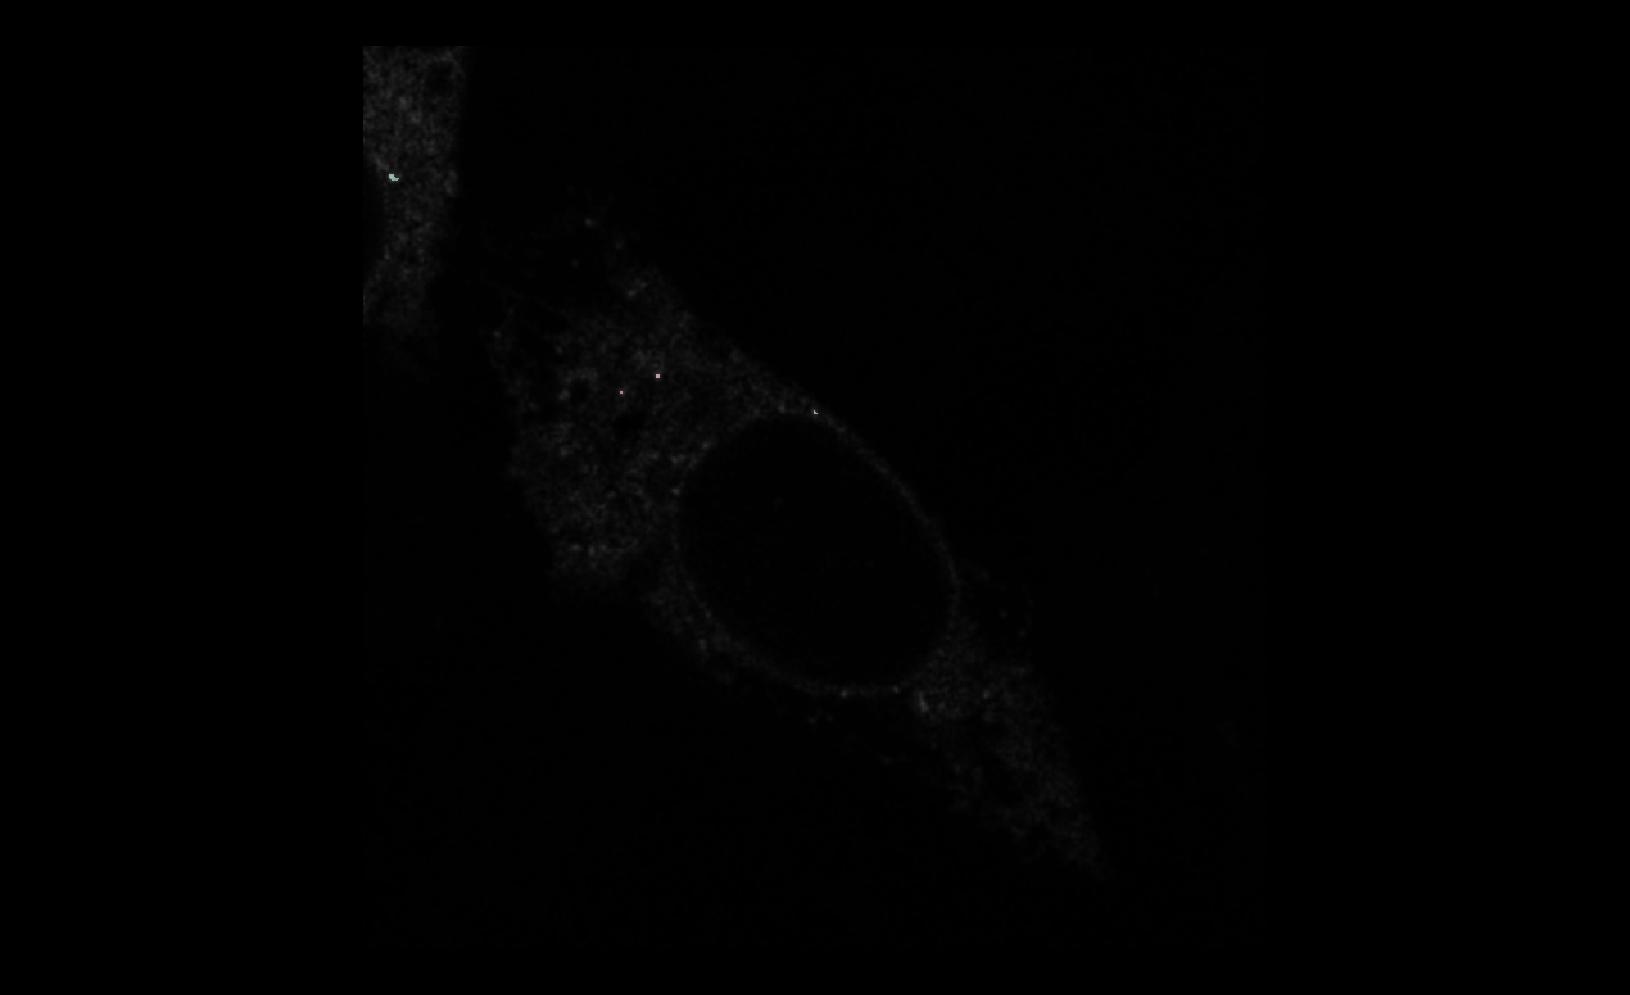

In [20]:
from napari.utils.notebook_display import nbscreenshot

nbscreenshot(viewer, canvas_only=True)

In [21]:
viewer.close()

-------------
## SUMMARY

The above details how the peroxisome object is inferred.  

### NEXT: INFER ENDOPLASMIC RETICULUM

proceed to [08_infer_ER.ipynb](./08_infer_ER.ipynb)
